In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
import os
import mimetypes
from pathlib import Path
from functools import partial

get_ext = lambda x: [i for i,j in mimetypes.types_map.items() if j.startswith(x)]

image_ext = get_ext('image')
video_ext = get_ext('video')
text_ext = get_ext('video')

join_path = lambda x,y: Path(os.path.join(x, y))

def get_files(root, file_type=None, recursive=True):
    files = []
    if file_type: file_type = tuple(file_type)
    if not recursive:
        files.extend([join_path(root, i) for i in os.listdir(root) if str(i).lower().endswith(file_type)])
    else:
        for p, d, fs in os.walk(root):
            if file_type:
                files.extend([join_path(p, f) for f in fs if str(f).lower().endswith(file_type)])
            else:
                files.extend([join_path(p, f) for f in fs])
    return files


get_image_files = partial(get_files, file_type = image_ext)
get_video_files = partial(get_files, file_type = video_ext)
get_text_files = partial(get_files, file_type = text_ext)

In [3]:
target_rank = np.arange(10)[:, np.newaxis].repeat(5, axis=1).T
predicted_rank = target_rank.copy()

for i in range(5):
    np.random.shuffle(target_rank[i])
for i in range(5):
    np.random.shuffle(predicted_rank[i])

In [4]:
print(f"Target rank of first class: {target_rank[0]}")
print(f"Predicted rank of first class: {predicted_rank[0]}")

Target rank of first class: [8 3 4 1 7 0 5 2 6 9]
Predicted rank of first class: [6 4 8 9 3 2 5 0 1 7]


In [5]:
(predicted_rank[:, 0] == target_rank[:, 0]) / target_rank.shape[1]

array([0., 0., 0., 0., 0.])

In [6]:
recall_at_1 = (predicted_rank[:, 0] == target_rank[:, 0])/target_rank.shape[1]
print(f"Recall@1: {recall_at_1}")

Recall@1: [0. 0. 0. 0. 0.]


In [7]:
recall_at_5 = np.array([np.intersect1d(predicted_rank[c, :5], target_rank[c, :5]).shape[0]/target_rank.shape[0] for c in range(5)])
print(f"Recall@5: {recall_at_5}")

Recall@5: [0.6 0.8 0.4 0.2 0.4]


In [8]:
recall_at = lambda k:  np.array([np.intersect1d(predicted_rank[c, :k], target_rank[c, :k]).shape[0] / target_rank.shape[1] for c in range(5)])
precision_at = lambda k:  np.array([np.intersect1d(predicted_rank[c, :k], target_rank[c, :k]).shape[0] / k for c in range(5)])

In [9]:
recall_at_10 = np.array([recall_at(k) for k in range(1, 11)])
print(recall_at_10[:, 0])

[0.  0.  0.2 0.2 0.3 0.3 0.4 0.6 0.8 1. ]


In [10]:
precision_at_10 = np.array([precision_at(k) for k in range(1, 11)])
print(precision_at_10[:,0])

[0.         0.         0.66666667 0.5        0.6        0.5
 0.57142857 0.75       0.88888889 1.        ]


In [11]:
AP_0_at_10 = np.sum(precision_at_10[1:, 0] * (recall_at_10[1:, 0] - recall_at_10[:-1, 0]))
print(AP_0_at_10)

0.7782539682539682


In [12]:
AP_at_10 = np.sum(precision_at_10[1:, :] * (recall_at_10[1:, :] - recall_at_10[:-1, :]), axis=0)
print(AP_at_10)

[0.77825397 0.79865079 0.75674603 0.74007937 0.73007937]


In [13]:
mAP_at_10 = np.mean(AP_at_10)
print(mAP_at_10)

0.7607619047619048


In [14]:
acc_k = lambda k: np.array([np.isin(c, target_rank[c, :k]) * 1 for c in range(5)])
print(acc_k(6))

[1 0 1 0 1]


In [15]:
cmc = np.mean(acc_k(6))
print(cmc)

0.6


In [16]:
# Download dataset
!git clone https://github.com/brendenlake/omniglot
!unzip -q omniglot/python/images_background
!unzip -q omniglot/python/images_evaluation

Cloning into 'omniglot'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


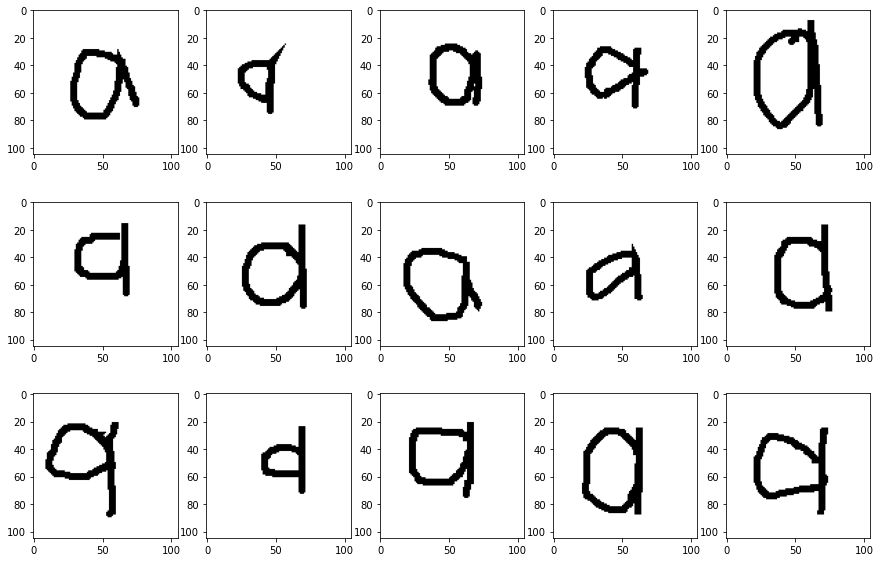

In [17]:
from pathlib import Path


latin_a = Path("images_background") / "Latin" / "character01"
paths = list(latin_a.glob("*.png"))

_, axs = plt.subplots(3, 5, figsize=(15, 10))

for i in range(15):
    image = Image.open(paths[i])
    axs[i % 3][i % 5].imshow(image)

In [18]:
data = {
    "train": {"labels": [], "image_paths": [], "cls2label": {}, "root": Path("images_background")},
    "valid": {"labels": [], "image_paths": [], "cls2label": {}, "root": Path("images_evaluation")}
}

for part in data:
    cur_part = data[part]
    for alphabet_path in cur_part["root"].iterdir():
        for ch in alphabet_path.iterdir():
            cur_part["labels"].extend(f"{alphabet_path.name}_{ch.name}" for _ in ch.glob("*.png"))
            cur_part["image_paths"].extend(ch.glob("*.png"))
    
    cur_part["labels"] = np.array(cur_part["labels"])
    cur_part["image_paths"] = np.array(cur_part["image_paths"])
    cur_part["cls2label"] = {c: num for num, c in enumerate(np.unique(cur_part["labels"]))}

In [19]:
import torch
from catalyst.contrib.utils.cv.image import imread
from catalyst.data.dataset.metric_learning import (
    MetricLearningTrainDataset,
    QueryGalleryDataset,
)
from torch.utils.data import Dataset


class OmniGlotMLDataset(MetricLearningTrainDataset):
    def __init__(
        self,
        images,
        targets,
        transform=None
    ):
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        img, target = self.images[index], int(self.targets[index])
        img = imread(img)

        if self.transform is not None:
            img = self.transform(image=img)["image"]
        
        return img, target

    def get_labels(self):
        return self.targets.tolist()

    def __len__(self):
        return self.images.shape[0]

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [20]:
class OmniGlotQGDataset(QueryGalleryDataset):

    def __init__(
        self,
        images,
        targets,
        transform=None,
        gallery_fraq=0.2,
    ):
        self._omniglot = OmniGlotMLDataset(
            images=images, targets=targets, transform=transform
        )

        self._gallery_size = int(gallery_fraq * len(self._omniglot))
        self._query_size = len(self._omniglot) - self._gallery_size

        self._is_query = torch.zeros(len(self._omniglot)).type(torch.bool)
        self._is_query[: self._query_size] = True

    def __getitem__(self, idx: int):
        # gather and return images, targets and query flag
        image, label = self._omniglot[idx]
        return {'features': image, 
               'targets': label,
               'is_query': self._is_query[idx]}

    def __len__(self):
        return len(self._omniglot)

    @property
    def gallery_size(self):
        return self._gallery_size

    @property
    def query_size(self):
        return self._query_size

In [21]:
from torch.utils.data import DataLoader, Sampler


class BalanceBatchSampler(Sampler):
    """
    This kind of sampler can be used for both metric learning and
    classification task.
    Sampler with the given strategy for the C unique classes dataset:
    - Selection P of C classes for the 1st batch
    - Selection K instances for each class for the 1st batch
    - Selection P of C - P remaining classes for 2nd batch
    - Selection K instances for each class for the 2nd batch
    - ...
    The epoch ends when there are no classes left.
    So, the batch sise is P * K except the last one.
    Thus, in each epoch, all the classes will be selected once, but this
    does not mean that all the instances will be selected during the epoch.
    One of the purposes of this sampler is to be used for
    forming triplets and pos/neg pairs inside the batch.
    To guarante existance of these pairs in the batch,
    P and K should be > 1. (1)
    Behavior in corner cases:
    - If a class does not contain K instances,
    a choice will be made with repetition.
    - If C % P == 1 then one of the classes should be dropped
    otherwise statement (1) will not be met.
    This type of sampling can be found in the classical paper of Person Re-Id,
    where P equals 32 and K equals 4:
    `In Defense of the Triplet Loss for Person Re-Identification`_.
    .. _In Defense of the Triplet Loss for Person Re-Identification:
        https://arxiv.org/abs/1703.07737
    """

    def __init__(self, labels, p, k):
        """
        Args:
            labels: list of classes labeles for each elem in the dataset
            p: number of classes in a batch, should be > 1
            k: number of instances of each class in a batch, should be > 1
        """
        super().__init__(self)
        classes = set(labels)

        self._labels = labels
        self._p = p
        self._k = k

        self._batch_size = self._p * self._k
        self._classes = classes

        # to satisfy statement (1)
        num_classes = len(self._classes)
        if num_classes % self._p == 1:
            self._num_epoch_classes = num_classes - 1
        else:
            self._num_epoch_classes = num_classes

    @property
    def batch_size(self):
        """
        Returns:
            this value should be used in DataLoader as batch size
        """
        return self._batch_size

    @property
    def batches_in_epoch(self):
        """
        Returns:
            number of batches in an epoch
        """
        return int(np.ceil(self._num_epoch_classes / self._p))

    def __len__(self):
        """
        Returns:
            number of samples in an epoch
        """
        return self._num_epoch_classes * self._k

    def __iter__(self):
        """
        Returns:
            indeces for sampling dataset elems during an epoch
        """
        inds = []

        for cls_id in sample(self._classes, self._num_epoch_classes):
            all_cls_inds = find_value_ids(self._labels, cls_id)

            # we've checked in __init__ that this value must be > 1
            num_samples_exists = len(all_cls_inds)

            if num_samples_exists < self._k:
                selected_inds = sample(
                    all_cls_inds, k=num_samples_exists
                ) + choices(all_cls_inds, k=self._k - num_samples_exists)
            else:
                selected_inds = sample(all_cls_inds, k=self._k)

            inds.extend(selected_inds)

        return iter(inds)

In [22]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor


IMAGE_SIZE = 64

transform = albu.Compose([
    albu.LongestMaxSize(IMAGE_SIZE),
    albu.PadIfNeeded(IMAGE_SIZE, IMAGE_SIZE, border_mode=0),
    albu.Normalize(),
    ToTensor()
])

In [23]:
train_images = data["train"]["image_paths"]
train_labels = data["train"]["labels"]

indexes = np.arange(train_images.shape[0])
np.random.shuffle(indexes)
train_images = train_images[indexes]
train_targets = np.array([data["train"]["cls2label"][c] for c in train_labels])[indexes]

dataset_train = OmniGlotMLDataset(images=train_images, targets=train_targets, transform=transform)
sampler = BalanceBatchSampler(labels=dataset_train.get_labels(), p=8, k=16)
train_loader = DataLoader(dataset=dataset_train, sampler=sampler, batch_size=sampler.batch_size)

In [24]:
valid_images = data["valid"]["image_paths"]
valid_labels = data["valid"]["labels"]
valid_targets = np.array([data["valid"]["cls2label"][c] for c in valid_labels])

dataset_valid = OmniGlotQGDataset(images=valid_images, targets=valid_targets, transform=transform, gallery_fraq=0.2)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=256)

In [25]:
from itertools import combinations, product
from random import sample
from sys import maxsize

from catalyst.data import InBatchTripletsSampler
from catalyst.contrib.utils.misc import find_value_ids
from catalyst.data.utils import convert_labels2list
from catalyst.utils.torch import normalize


class AllTripletsSampler(InBatchTripletsSampler):
    """
    This sampler selects all the possible triplets for the given labels
    """

    def __init__(self, max_output_triplets=maxsize):
        """
        Args:
            max_output_triplets: with the strategy of choosing all
                the triplets, their number in the batch can be very large,
                because of it we can sample only random part of them,
                determined by this parameter.
        """
        self._max_out_triplets = max_output_triplets

    def _sample(self, *_, labels):
        """
        Args:
            labels: labels of the samples in the batch
            *_: note, that we ignore features argument
        Returns: indeces of triplets
        """
        num_labels = len(labels)

        triplets = []
        for label in set(labels):
            ids_pos_cur = set(find_value_ids(labels, label))
            ids_neg_cur = set(range(num_labels)) - ids_pos_cur

            pos_pairs = list(combinations(ids_pos_cur, r=2))

            tri = [(a, p, n) for (a, p), n in product(pos_pairs, ids_neg_cur)]
            triplets.extend(tri)

        triplets = sample(triplets, min(len(triplets), self._max_out_triplets))
        ids_anchor, ids_pos, ids_neg = zip(*triplets)

        return list(ids_anchor), list(ids_pos), list(ids_neg)

In [26]:
import torch.nn as nn


class TripletMarginLossWithSampler(nn.Module):
    """
    This class combines in-batch sampling of triplets and
    default TripletMargingLoss from PyTorch.
    """

    def __init__(self, margin, sampler_inbatch):
        """
        Args:
            margin: margin value
            sampler_inbatch: sampler for forming triplets inside the batch
        """
        super().__init__()
        self._sampler_inbatch = sampler_inbatch
        self._triplet_margin_loss = TripletMarginLoss(margin=margin)

    def forward(self, features, labels):
        """
        Args:
            features: features with the shape of [batch_size, features_dim]
            labels: labels of samples having batch_size elements
        Returns: loss value
        """
        labels_list = convert_labels2list(labels)

        (
            features_anchor,
            features_positive,
            features_negative,
        ) = self._sampler_inbatch.sample(features=features, labels=labels_list)

        loss = self._triplet_margin_loss(
            anchor=features_anchor,
            positive=features_positive,
            negative=features_negative,
        )
        return loss

In [34]:
from catalyst import dl, utils
from catalyst.contrib import models
from catalyst.contrib.nn import TripletMarginLossWithSampler, RAdam

from torchvision.models import mobilenet_v2, resnet18


base_model = resnet18(pretrained=True)
model = nn.Sequential(
        nn.Sequential(*list(base_model.children())[:-1]),
        nn.Flatten()
)
optimizer = RAdam(model.parameters(), lr=0.01)

# 3. criterion with triplets sampling
sampler_inbatch = AllTripletsSampler()
criterion = TripletMarginLossWithSampler(margin=0.3, sampler_inbatch=sampler_inbatch)

# 4. training with catalyst Runner
callbacks = [
    dl.ControlFlowCallback(dl.CriterionCallback(), loaders="train"),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[5]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=1),
]

In [ ]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=1,
    main_metric="cmc05",
)

In [ ]:
class HardTripletsSampler(InBatchTripletsSampler):
    """
    This sampler selects hardest triplets based on distances between features:
    the hardest positive sample has the maximal distance to the anchor sample,
    the hardest negative sample has the minimal distance to the anchor sample.
    Note that a typical triplet loss chart is as follows:
    1. Falling: loss decreases to a value equal to the margin.
    2. Long plato: the loss oscillates near the margin.
    3. Falling: loss decreases to zero.
    """

    def __init__(self, norm_required=False):
        """
        Args:
            norm_required: set True if features normalisation is needed
        """
        self._norm_required = norm_required

    def _sample(self, features, labels):
        """
        This method samples the hardest triplets inside the batch.
        Args:
            features: has the shape of [batch_size, feature_size]
            labels: labels of the samples in the batch
        Returns:
            the batch of the triplets in the order below:
            (anchor, positive, negative)
        """
        assert features.shape[0] == len(labels)

        if self._norm_required:
            features = normalize(samples=features.detach())

        dist_mat = torch.cdist(x1=features, x2=features, p=2)

        ids_anchor, ids_pos, ids_neg = self._sample_from_distmat(
            distmat=dist_mat, labels=labels
        )

        return ids_anchor, ids_pos, ids_neg

    @staticmethod
    def _sample_from_distmat(distmat, labels):
        """
        This method samples the hardest triplets based on the given
        distances matrix. It chooses each sample in the batch as an
        anchor and then finds the harderst positive and negative pair.
        Args:
            distmat: matrix of distances between the features
            labels: labels of the samples in the batch
        Returns:
            the batch of triplets in the order below:
            (anchor, positive, negative)
        """
        ids_all = set(range(len(labels)))

        ids_anchor, ids_pos, ids_neg = [], [], []

        for i_anch, label in enumerate(labels):
            ids_label = set(find_value_ids(it=labels, value=label))

            ids_pos_cur = np.array(list(ids_label - {i_anch}), int)
            ids_neg_cur = np.array(list(ids_all - ids_label), int)

            i_pos = ids_pos_cur[distmat[i_anch, ids_pos_cur].argmax()]
            i_neg = ids_neg_cur[distmat[i_anch, ids_neg_cur].argmin()]

            ids_anchor.append(i_anch)
            ids_pos.append(i_pos)
            ids_neg.append(i_neg)

        return ids_anchor, ids_pos, ids_neg

In [ ]:
base_model = mobilenet_v2(pretrained=True)
model = nn.Sequential(
        base_model.features,
        nn.AdaptiveMaxPool2d((1, 1)),
        nn.Flatten()
)
optimizer = RAdam(model.parameters(), lr=0.01)

# 3. criterion with triplets sampling
sampler_inbatch = HardTripletsSampler()
criterion = TripletMarginLossWithSampler(margin=0.3, sampler_inbatch=sampler_inbatch)

# 4. training with catalyst Runner
callbacks = [
    dl.ControlFlowCallback(dl.CriterionCallback(), loaders="train"),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[5]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=1),
]

In [ ]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=1,
    main_metric="cmc05",
)

In [ ]:
import math

import torch.nn.functional as F


class CosFace(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        s: float = 10,
        m: float = 0.25,
    ):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(
            torch.FloatTensor(out_features, in_features)
        )
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, target):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size()).to(input.device)
        one_hot.scatter_(1, target.view(-1, 1).long(), 1)
        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s

        return logits

In [ ]:
dataset_train = OmniGlotMLDataset(images=train_images, targets=train_targets, transform=transform)
train_loader = DataLoader(dataset=dataset_train, batch_size=sampler.batch_size)

dataset_valid = OmniGlotQGDataset(images=valid_images, targets=valid_targets, transform=transform, gallery_fraq=0.2)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=256)

In [ ]:
class OmniGlotModel(nn.Module):
    def __init__(self, num_training_classes):
        super().__init__()

        base_model = mobilenet_v2(pretrained=True)
        self.feature_extractor = nn.Sequential(
                base_model.features,
                nn.AdaptiveMaxPool2d((1, 1)),
                nn.Flatten(),
        )

        self.face = CosFace(1280, num_training_classes)

    def forward(self, features, targets=None):
        features = self.feature_extractor(features)
        if self.training and (targets is not None):
            output = self.face(features, targets)
        else:
            output = F.normalize(features)
        return output

In [ ]:
class FaceRunner(dl.SupervisedRunner):
    def predict_batch(self, batch):
        return {"features": self.model(batch["features"].to(self.device)), "targets": batch["targets"]}

    def _handle_batch(self, batch):
        if self.model.training:
            y_pred = self.model(batch["features"], batch["targets"])
        else:
            y_pred = self.model(batch["features"])
        self.output = {"logits": y_pred}

In [ ]:
model = OmniGlotModel(np.unique(train_labels).shape[0])
optimizer = RAdam(model.parameters(), lr=0.1)

criterion = nn.CrossEntropyLoss()

callbacks = [
    dl.ControlFlowCallback(dl.CriterionCallback(), loaders="train"),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[5]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=1),
]

In [ ]:
runner = FaceRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=1,
    main_metric="cmc05",
)

In [ ]:
import seaborn as sns

from umap import UMAP

In [ ]:
results = {"features": [], "targets": []}
for prediction in runner.predict_loader(loader=valid_loader):
    results["features"].extend(feature for feature in prediction["features"].cpu().numpy())
    results["targets"].extend(feature for feature in prediction["targets"].cpu().numpy())

In [ ]:
proj = UMAP(n_components=2)
new_features = proj.fit_transform(np.array(results["features"])[np.isin(results["targets"],np.arange(10))])

In [ ]:
plot = {"x": new_features[:, 0], "y": new_features[:, 1], "color": np.array(results["targets"])[np.isin(results["targets"],np.arange(10))]}

sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x="x", y="y", hue="color", data=plot, ax=ax)